# Chapter 11 Practice Answers

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy
from watermark import watermark
from causalgraphicalmodels import CausalGraphicalModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark

Last updated: 2024-07-06T19:38:48.464098-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
%watermark --iversions

pymc      : 5.9.2
numpy     : 1.25.2
scipy     : 1.11.3
pandas    : 2.1.3
arviz     : 0.16.1
matplotlib: 3.8.2



# 11E1
If an event has probability 0.35, what are the log-odds of this event

In [43]:
#11E1
def prob_to_log_odds(x):
    return np.log(x/(1-x))
prob_to_log_odds(0.35)

-0.6190392084062235

# 11E2. 
If an event has log-odds 3.2, what is the probability of this event?

In [44]:
#11E2
def log_odds_to_prob(x):
    return np.exp(x)/(np.exp(x)+1)

log_odds_to_prob(3.2)

0.9608342772032357

#11E3. 
Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about
the proportional change in odds of the outcome?

In [45]:
#11E3
prop_odds = np.round(np.exp(1.7),3)
print(f'The Prob Odds is {prop_odds}')

The Prob Odds is 5.474


This means that for each unit increase of the underlying predictor, the proportional increase in odds of the outcome by is 5.5

# 11E4. 
Why do Poisson regressions sometimes require the use of an offset? Provide an example.

## 11E4 Answer: 
The offset is used to when we want to make sure that data collected at different time periods can be used together in a Poisson regression.  For example, let's say we want to compare the number of customers at two stores, but one store has daily counts, and the other has weekly counts.  To use these in the same model, we would use the offest

# 11M1. 
As explained in the chapter, binomial data can be organized in aggregated and disaggregated
forms, without any impact on inference. But the likelihood of the data does change when the data are
converted between the two formats. Can you explain why?

## 11M1 Answer.  
When we use an aggregated view versus a disaggregated view, we are basically looking at two seperate probability distributions - binomial for the aggregated, and bernouli for the disaggregated view.  This means that for the aggregated data, we have to account for all the differnt ways an outcome (e.g. 2 heads out of 4 coin tosses) can occur.  But with the bernouli trials, we know the order.  So for the aggregated view, we have an extra factor to account for the different ways it can occur.  So this leads to a different likelihood depending on if you are using an aggregated or disaggregated view

# 11M2. 
If a coefficient in a Poisson regression has value 1.7, what does this imply about the change
in the outcome

In [46]:
# 11M2 Answer
np.exp(1.7)

5.4739473917272

This means that for each unit increase of the underlying predictor, the proportional increase in odds of the outcome by is 5.5

# 11M3
 Explain why the logit link is appropriate for a binomial generalized linear model.

#11M3 Answer
We need to map our data to the outcome probability space between 0 and 1.  The logit does this.  The logit also forces a sharp rise between 0 and 1

# 11M4. 
Explain why the log link is appropriate for a Poisson generalized linear model.

## 11M4 Answer
We need to map our data to a strictly postive outcome, and that is what the log-link does.

# 11M5 Question:
What would it imply to use a logit link for the mean of a Poisson generalized linear model? Can you think of a real research problem for which this would make sense?

## 11M5 Answer: A logit model typically works when the maximum count is 1, or that each trial is a 1 or a 0.  However, It being 1 is abitrary, so if the maximum number is known, we could use a logic with a poisson distribution.  The log link is used when the max count is unknown

# 11M6 Question:
State the constraints for which the binomial and Poisson distributions have maximum entropy. Are the constraints different at all for binomial and Poisson? Why or why not?


## 11M6 Answer: 
The constraints for bernouli and binomial is 

1) Two Outcomes
2) Each outcome has a constant probability

Logitsic and Posssion are variants of each other, where Logitstic has a known count and Possion does not.  So the maxium entropy constraints are the same.

In [47]:
chimp_data = pd.read_csv('./data/chimpanzees.csv', sep = ';')
#chimp_data['actor'] = chimp_data['actor'] - 1
chimp_data.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [48]:
chimp_data['treatment'] = 1 + chimp_data['prosoc_left'] + 2*chimp_data['condition']

# 11M7. Use quap to construct a quadratic approximate posterior distribution for the chimpanzee model that includes a unique intercept for each actor, m11.4 (page 330). Compare the quadratic approximation to the posterior distribution produced instead from MCMC. Can you explain both the differences and the similarities between the approximate and the MCMC distributions? Relax the prior on the actor intercepts to Normal(0,10). Re-estimate the posterior using both ulam and quap. Do the differences increase or decrease? Why?


In [49]:
#This code is from the pymc3-quap package.  The package import kept failing, so I just copied the function from that quap.py file to here
#so I could skip the imports
def quap(vars, n_samples=10_000):
    """Finds the quadratic approximation to the posterior, also known as the Laplace approximation.

    NOTE: The quadratic approximation only works well for unimodal and roughly symmetrical posteriors of continuous variables.
    The usual MCMC convergence and mixing statistics (e.g. R-hat, ESS) will NOT tell you anything about how well this approximation fits your actual (unknown) posterior, indeed they'll always be extremely nice since all samples are from exactly the same distribution, the posterior quadratic approximation.
    Use at your own risk.

    See Chapter 4 of "Bayesian Data Analysis" 3rd edition for background.

    Returns an arviz.InferenceData object for compatibility by sampling from the approximated quadratic posterior. Note these are NOT MCMC samples.

    Also returns the exact posterior approximation as a scipy.stats.multivariate_normal distribution.

    Parameters
    ----------
    vars: list
        List of variables to approximate the posterior for.
    n_samples: int
        How many samples to sample from the approximate posterior.

    Returns
    -------
    arviz.InferenceData:
        InferenceData with samples from the approximate posterior
    scipy.stats.multivariate_normal:
        Multivariate normal posterior approximation
    """
    map = pm.find_MAP(vars=vars)
    H = pm.find_hessian(map, vars=vars)
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(map[v.name]) for v in vars])
    posterior = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    draws = posterior.rvs(n_samples)[np.newaxis, ...]
    if draws.ndim == 2:
        draws = draws[..., np.newaxis]
    samples = {}
    i = 0
    for v in vars:
        var_size = map[v.name].size
        samples[v.name] = draws[:, :, i: i + var_size]
        if var_size == 1:
            samples[v.name] = samples[v.name].squeeze(axis=-1)
        i += var_size
    return az.convert_to_inference_data(samples), posterior

In [50]:
actor_cat = pd.Categorical(chimp_data['actor'])
treatment_cat = pd.Categorical(chimp_data['treatment'])

In [51]:
with pm.Model() as m_11m7_quap_a:
    a = pm.Normal('a', 0,1.5, shape=len(actor_cat.categories))
    b = pm.Normal('b',0,0.5, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a[actor_cat.codes] + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    quap_idata_a, quap_posterior_a = quap([a,b])
    #m_11m7_quap_trace = pm.sample()

with pm.Model() as m_11m7_hmc_a:
    a = pm.Normal('a', 0,1.5, shape=len(actor_cat.categories))
    b = pm.Normal('b',0,0.5, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a[actor_cat.codes] + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    m_11m7_hmc_trace_a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [52]:
quap_idata_a

Inference data with groups:
	> posterior

In [53]:
m_11m7_hmc_trace_a

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

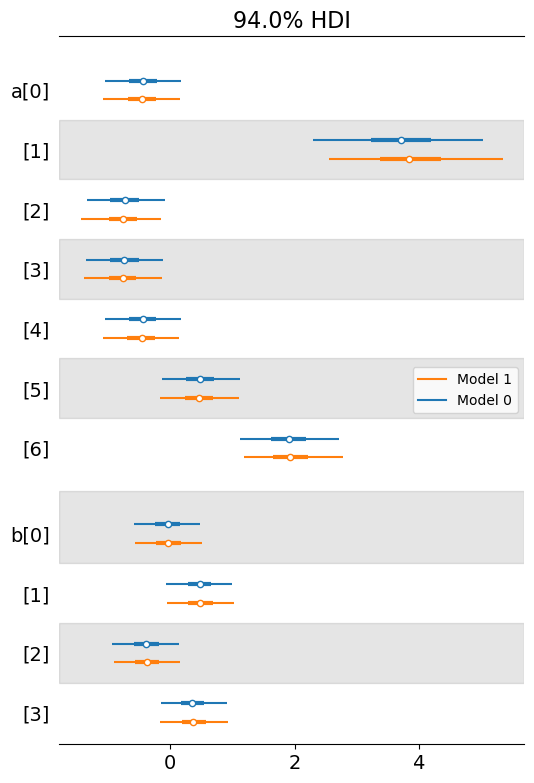

In [54]:
az.plot_forest([quap_idata_a,m_11m7_hmc_trace_a], var_names=['a','b'], combined=True)

With exception of the second actor, most everythign looks the same

In [55]:
with pm.Model() as m_11m7_quap_b:
    a = pm.Normal('a', 0,10, shape=len(actor_cat.categories))
    b = pm.Normal('b',0,0.5, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a[actor_cat.codes] + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    quap_idata_b, quap_posterior_b = quap([a,b])
    #m11_4_quap_trace = pm.sample()

with pm.Model() as  m_11m7_hmc_b:
    a = pm.Normal('a', 0,10, shape=len(actor_cat.categories))
    b = pm.Normal('b',0,0.5, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a[actor_cat.codes] + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    m_11m7_hmc_trace_b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

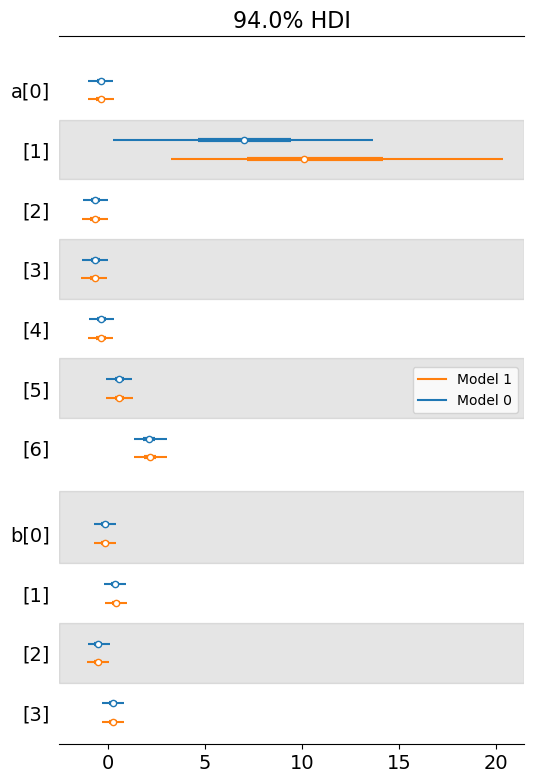

In [56]:
az.plot_forest([quap_idata_b,m_11m7_hmc_trace_b], var_names=['a','b'], combined=True)

The differences for the 2nd actor are more pronounced now.  I think this illustrates the benefits of HMC, which gives a more honest view of the posterior distribution because it has fewer assumptions that the Quadtric Approximation

# 11M8 Question. 
Revisit the data(Kline) islands example. This time drop Hawaii from the sample and refit
the models. What changes do you observe?

In [57]:
#11M8
kline_data = pd.read_csv('./data/Kline',sep=';')
kline_data.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


In [58]:
def normalize(x):
    return (x - x.mean()) / x.std()

In [59]:
kline_data['pop_ln'] = normalize(np.log(kline_data['population']))

In [60]:
cid = (kline_data['contact'] == 'high').astype(int)

In [61]:
with pm.Model() as m_11m8:
    a = pm.Normal('a', 3,0.5, shape=2)
    b = pm.Normal('b',0,0.2, shape=2) 
    p = pm.Deterministic("p", pm.math.log(a[cid] + b[cid]))
    T = pm.Poisson('pulled_left',p,observed=kline_data['total_tools'])
    m_11m8_trace = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_11m8_no_hawaii:
    a = pm.Normal('a', 3,0.5, shape=2)
    b = pm.Normal('b',0,0.2, shape=2) 
    p = pm.Deterministic("p", pm.math.log(a[cid[~(kline_data['culture'] == 'Hawaii')]] + b[cid[~(kline_data['culture'] == 'Hawaii')]]))
    T = pm.Poisson('pulled_left',p,observed=kline_data[~(kline_data['culture'] == 'Hawaii')]['total_tools'])
    m_11m8_no_hawaii_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [62]:
az.summary(m_11m8_trace, var_names=['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],6.048,0.381,5.372,6.777,0.005,0.004,5951.0,3774.0,1.0
a[1],6.379,0.383,5.643,7.086,0.005,0.004,5226.0,3430.0,1.0
b[0],0.492,0.195,0.135,0.861,0.003,0.002,5861.0,3325.0,1.0
b[1],0.542,0.191,0.195,0.902,0.003,0.002,5206.0,3480.0,1.0


In [63]:
az.summary(m_11m8_no_hawaii_trace, var_names=['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],5.159,0.401,4.434,5.910,0.005,0.004,5305.0,3349.0,1.0
a[1],6.379,0.380,5.700,7.116,0.005,0.004,5589.0,3059.0,1.0
b[0],0.348,0.192,0.002,0.734,0.002,0.002,5965.0,3170.0,1.0
b[1],0.548,0.196,0.191,0.921,0.002,0.002,6277.0,3137.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

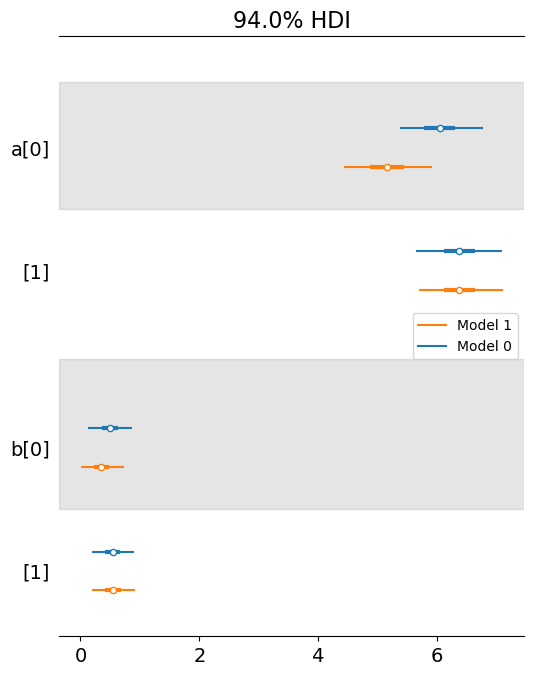

In [64]:
az.plot_forest([m_11m8_trace,m_11m8_no_hawaii_trace], var_names=['a','b'], combined=True)

We can see that removing Hawaii shifts the intercept quite a bit, and the slope to a lesser degree

# 11H1 Question
Use WAIC or PSIS to compare the chimpanzee model that includes a unique intercept for
each actor, m11.4 (page 330), to the simpler models fit in the same section. Interpret the results.

In [65]:
#11H1

with pm.Model() as m_11h1_1:
    a = pm.Normal('a', 0,10)
    p = pm.Deterministic("p", pm.invlogit(a))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    m_11h1_1_trace = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_11h1_2:
    a = pm.Normal('a', 0,1.5)
    b = pm.Normal('b',0,10, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    m_11h1_2_trace = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_11h1_3:
    a = pm.Normal('a', 0,1.5)
    b = pm.Normal('b',0, 0.5, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    m_11h1_3_trace = pm.sample(idata_kwargs={"log_likelihood": True})
    
with pm.Model() as m_11h1_4:
    a = pm.Normal('a', 0,1.5, shape=len(actor_cat.categories))
    b = pm.Normal('b',0,0.5, shape=len(treatment_cat.categories)) 
    p = pm.Deterministic("p", pm.invlogit(a[actor_cat.codes] + b[treatment_cat.codes]))
    pulled_left = pm.Binomial('pulled_left',1,p,observed=chimp_data['pulled_left'])
    m_11h1_4_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [71]:
compare_11_h1 = {
    "11.1": m_11h1_1_trace, 
    "11.2": m_11h1_2_trace, 
    "11.3": m_11h1_3_trace,
    "11.4": m_11h1_4_trace}
az.compare(compare_11_h1, ic='loo',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
11.4,0,532.146480,8.418285,0.000000,1.000000e+00,18.892148,0.000000,False,deviance
11.3,1,682.408802,3.603604,150.262322,0.000000e+00,9.179418,18.366110,False,deviance
11.2,2,682.825890,3.885863,150.679410,0.000000e+00,9.629191,18.421006,False,deviance
11.1,3,687.892558,0.976225,155.746078,3.801404e-11,7.113543,18.909291,False,deviance


We can see that there is not much difference between 11.1,11.2, and 11.3.  11.4 performs the best, which tells us the individual chimps are driving a lot of the variance in this model and the "treatment" has much less of an effect

# 11H2. 
The data contained in library(MASS);data(eagles) are records of salmon pirating attempts by Bald Eagles in Washington State. See ?eagles for details. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the “victim” and the thief the “pirate.” Use the available data to build a binomial GLM of successful pirating attempts.

a. Consider the following model:
yi ∼ Binomial(ni
, pi)
logit(pi) = α + βPPi + βVVi + βAAi
α ∼ Normal(0, 1.5)
βP, βV, βA ∼ Normal(0, 0.5)

where y is the number of successful attempts, n is the total number of attempts, P is a dummy variable
indicating whether or not the pirate had large body size, V is a dummy variable indicating whether
or not the victim had large body size, and finally A is a dummy variable indicating whether or not
the pirate was an adult. Fit the model above to the eagles data, using both quap and ulam. Is the
quadratic approximation okay?
(b) Now interpret the estimates. If the quadratic approximation turned out okay, then it’s okay
to use the quap estimates. Otherwise stick to ulam estimates. Then plot the posterior predictions.
Compute and display both (1) the predicted probability of success and its 89% interval for each row (i)
in the data, as well as (2) the predicted success count and its 89% interval. What different information
does each type of posterior prediction provide?
(c) Now try to improve the model. Consider an interaction between the pirate’s size and ag


In [73]:
##11H2
eagles_data = pd.read_csv('./Data/eagles.csv')

In [74]:
eagles_data['PirateSize'] = (eagles_data['P'] == 'L').astype(int)
eagles_data['VictimSize'] = (eagles_data['V'] == 'L').astype(int)
eagles_data['Adult'] = (eagles_data['A'] == 'A').astype(int)
eagles_data

,Unnamed: 0,y,n,P,A,V,PirateSize,VictimSize,Adult
0,1,17,24,L,A,L,1,1,1
1,2,29,29,L,A,S,1,0,1
2,3,17,27,L,I,L,1,1,0
3,4,20,20,L,I,S,1,0,0
4,5,1,12,S,A,L,0,1,1
5,6,15,16,S,A,S,0,0,1
6,7,0,28,S,I,L,0,1,0
7,8,1,4,S,I,S,0,0,0


In [75]:
with pm.Model() as m_11h2_quap:
    a = pm.Normal('a', 0,1.5)
    b_ps = pm.Normal('b_ps',0,0.5) 
    b_vs = pm.Normal('b_vs',0,0.5) 
    b_a = pm.Normal('b_a',0,0.5) 
    p = pm.Deterministic("p", pm.invlogit(a + b_ps*eagles_data['PirateSize'] + b_vs*eagles_data['VictimSize'] + b_a*eagles_data['Adult']))
    success = pm.Binomial('success',n=eagles_data['n'],p=p,observed=eagles_data['y'])
    m_11h2_quap_idata, m11_h2_quap_posterior = quap([a,b_ps,b_vs,b_a])

with pm.Model() as m_11h2_hmc:
    a = pm.Normal('a', 0,1.5)
    b_ps = pm.Normal('b_ps',0,0.5) 
    b_vs = pm.Normal('b_vs',0,0.5) 
    b_a = pm.Normal('b_a',0,0.5) 
    p = pm.Deterministic("p", pm.invlogit(a + b_ps*eagles_data['PirateSize'] + b_vs*eagles_data['VictimSize'] + b_a*eagles_data['Adult']))
    success = pm.Binomial('success',n=eagles_data['n'],p=p,observed=eagles_data['y'])
    m_11h2_hmc_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_ps, b_vs, b_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

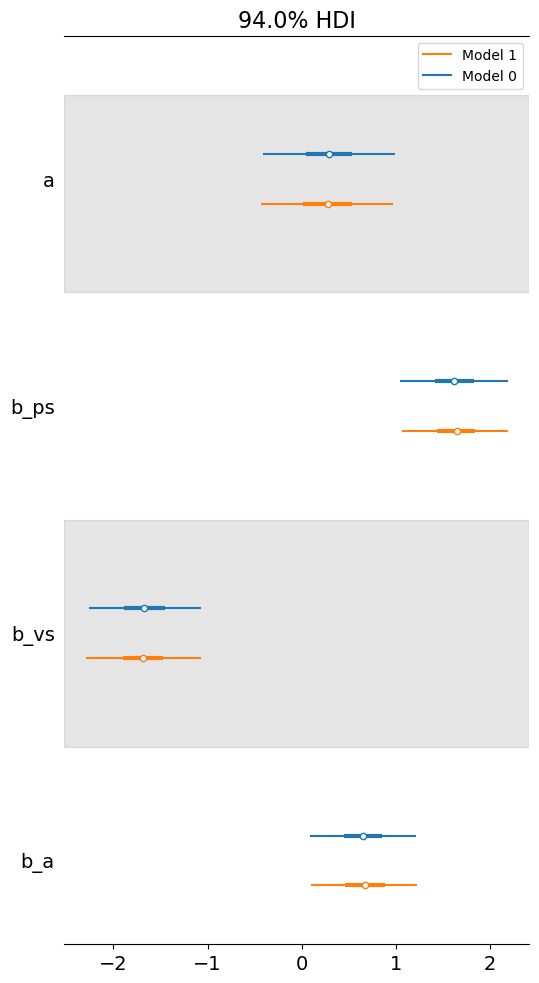

In [76]:
az.plot_forest([m_11h2_quap_idata,m_11h2_hmc_trace], var_names=['a','b_ps','b_vs','b_a'],combined=True)

For both the quap and hmc models, the distributions of coefficients are very similar.  So it's probably fine to use either one, but we'll use the hmc one.

In [78]:
az.summary(m_11h2_hmc_trace, var_names=['a','b_ps','b_vs','b_a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.284,0.379,-0.429,0.968,0.007,0.005,2824.0,2749.0,1.0
b_ps,1.650,0.303,1.070,2.195,0.005,0.004,3614.0,2404.0,1.0
b_vs,-1.688,0.325,-2.295,-1.075,0.006,0.004,3262.0,2500.0,1.0
b_a,0.673,0.309,0.101,1.228,0.006,0.004,3022.0,2921.0,1.0


Looking at this, the size of the pirate increases the odds of getting the fish. It's intesting the size of the victim has a negative slope - there might be an interaction there.  It makes sense that pirate being an adult is also increases the odds because being an adult is probably correlated with size

In [79]:
eagles_data['string'] = eagles_data['P'] + eagles_data['V'] + eagles_data['A']

In [84]:
with m_11h2_hmc:
    pp = pm.sample_posterior_predictive(m_11h2_hmc_trace, var_names=['p'])

Sampling: []


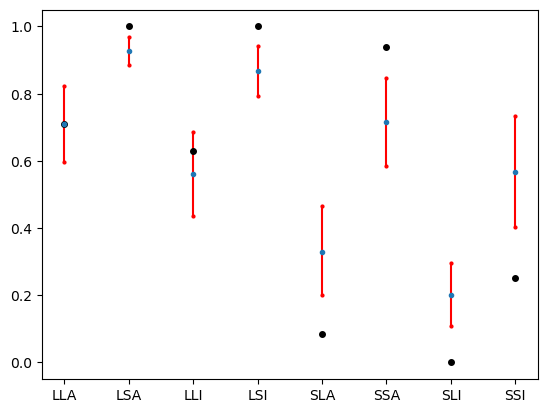

In [85]:
ys = az.hdi(m_11h2_hmc_trace)['p'].T.values
for num,value in enumerate(list(eagles_data['string'])):
    plt.plot([value,value] ,[ys[0][num], ys[1][num]],'ro-', ms=2)
plt.plot(eagles_data['string'], eagles_data['y']/eagles_data['n'], "ko", ms=4)
plt.plot(eagles_data['string'],pp['posterior_predictive']['p'].mean(['chain','draw']),'o',ms=3)

It seems like the model provides better predictions when the pirate is large.  Part of this might be because the sample sizes are smaller when the pirate is small, and it's not clear if this is a artifact of the data collection, or that small pirates are less likely to try.

In [86]:
with pm.Model() as m_11h2_hmc_2:
    a = pm.Normal('a', 0,1.5)
    b_ps = pm.Normal('b_ps',0,0.5) 
    b_vs = pm.Normal('b_vs',0,0.5) 
    b_a = pm.Normal('b_a',0,0.5) 
    b_ps_a = pm.Normal('b_ps_a',0,0.5)
    p = pm.Deterministic("p", pm.invlogit(a + b_ps*eagles_data['PirateSize'] + b_vs*eagles_data['VictimSize'] + b_a*eagles_data['Adult'] + b_ps_a*eagles_data['PirateSize']*eagles_data['Adult']))
    success = pm.Binomial('success',n=eagles_data['n'],p=p,observed=eagles_data['y'])
    m_11h2_hmc_2_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_ps, b_vs, b_a, b_ps_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [87]:
compare_11_h2 = {
    "No_Interaction": m_11h2_hmc_trace, 
    "Interaction": m_11h2_hmc_2_trace}
az.compare(compare_11_h2, ic='waic',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
No_Interaction,0,58.522610,8.107729,0.000000,1.0,11.240903,0.000000,True,deviance
Interaction,1,60.495749,8.982710,1.973139,0.0,11.641779,1.342928,True,deviance


The interaction doesn't seem to add much, which indicates there isn't a strong relaiontship between size and if the pirate is an adult.

The textbook doesn't ask for it, but let's try a 3rd model

In [88]:
with pm.Model() as m_11h2_hmc_3:
    a = pm.Normal('a', 0,1.5)
    b_ps = pm.Normal('b_ps',0,0.5, shape=2) 
    b_vs = pm.Normal('b_vs',0,0.5,shape=2) 
    b_a = pm.Normal('b_a',0,0.5,shape=2) 
    #b_ps_a = pm.Normal('b_ps_a',0,0.5)
    p = pm.Deterministic("p", pm.invlogit(a + b_ps[eagles_data['PirateSize']] + b_vs[eagles_data['VictimSize']] + b_a[eagles_data['Adult']]))
    success = pm.Binomial('success',n=eagles_data['n'],p=p,observed=eagles_data['y'])
    m_11h2_hmc_3_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_ps, b_vs, b_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [89]:
compare_11_h2 = {
    "No_Interaction": m_11h2_hmc_trace, 
    "Interaction": m_11h2_hmc_2_trace,
    "Categorical": m_11h2_hmc_3_trace}
az.compare(compare_11_h2, ic='waic',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is dep

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Categorical,0,45.717914,6.390746,0.000000,1.000000e+00,7.136113,0.000000,True,deviance
No_Interaction,1,58.522610,8.107729,12.804696,0.000000e+00,11.240903,5.589897,True,deviance
Interaction,2,60.495749,8.982710,14.777835,5.306866e-14,11.641779,5.475398,True,deviance


In [90]:
with m_11h2_hmc_3:
    pp = pm.sample_posterior_predictive(m_11h2_hmc_3_trace, var_names=['p'])

Sampling: []


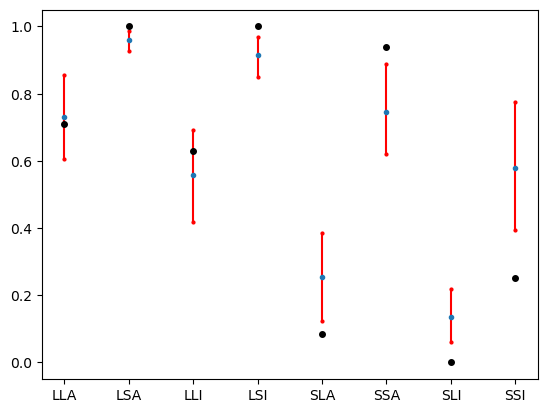

In [92]:
ys = az.hdi(m_11h2_hmc_3_trace)['p'].T.values
for num,value in enumerate(list(eagles_data['string'])):
    plt.plot([value,value] ,[ys[0][num], ys[1][num]],'ro-', ms=2)
plt.plot(eagles_data['string'], eagles_data['y']/eagles_data['n'], "ko", ms=4)
plt.plot(eagles_data['string'],pp['posterior_predictive']['p'].mean(['chain','draw']),'o',ms=3)

The categorical model is better on paper, but the plot shows that the improvement is minor, and may have increased the intervals as well.

# 11H4 Question. 
The data in data(NWOGrants) are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see van der Lee and Ellemers
(2015) for data and context). These data have a very similar structure to the UCBAdmit data discussed
in the chapter. I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through discipline. Draw the
corresponding DAG and then use one or more binomial GLMs to answer the question. What is your
causal interpretation? If NWO’s goal is to equalize rates of funding between men and women, what
type of intervention would be most effective?

In [94]:
#11H4
nwo_data = pd.read_csv('./data/NWOGrants.csv', sep=';')
nwo_data

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18
5,Physics,f,9,2
6,Humanities,m,230,33
7,Humanities,f,166,32
8,Technical sciences,m,189,30
9,Technical sciences,f,62,13


In [95]:
nwo_data['gender_id'] = (nwo_data["gender"] == "m").astype(int)
nwo_data.head()

,discipline,gender,applications,awards,gender_id
0,Chemical sciences,m,83,22,1
1,Chemical sciences,f,39,10,0
2,Physical sciences,m,135,26,1
3,Physical sciences,f,39,9,0
4,Physics,m,67,18,1


In [97]:
with pm.Model() as m_11h4:
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[nwo_data['gender_id']]))

    awards = pm.Binomial("awards", p=p, n=nwo_data['applications'], observed=nwo_data['awards'])

    m_11h4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [98]:
az.summary(m_11h4_trace, var_names=["a"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.74,0.08,-1.89,-1.59,0.0,0.0,4051.73,3197.32,1.0
a[1],-1.53,0.06,-1.65,-1.41,0.0,0.0,3966.37,2837.01,1.0


In [100]:
az.summary(log_odds_to_prob(m_11h4_trace['posterior']['a'][:,:,1]) - log_odds_to_prob(m_11h4_trace['posterior']['a'][:,:,0]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.028,0.014,0.001,0.053,0.0,0.0,3849.0,2476.0,1.0


Males have about a 3% higher proability of getting an award

In [101]:
#Adding Discipline to Model
dis_cat = pd.Categorical(nwo_data['discipline'])
dis_cat.codes

array([0, 0, 5, 5, 6, 6, 2, 2, 8, 8, 3, 3, 1, 1, 7, 7, 4, 4], dtype=int8)

In [102]:
with pm.Model() as m_11h4_2:
    a = pm.Normal("a", 0, 1.5, shape=2)
    d = pm.Normal("d", 0,1.5, shape=len(dis_cat.categories))
    p = pm.Deterministic("p", pm.math.invlogit(a[nwo_data['gender_id']] + d[dis_cat.codes]))

    awards = pm.Binomial("awards", p=p, n=nwo_data['applications'], observed=nwo_data['awards'])

    m_11h4_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [103]:
az.summary(m_11h4_2_trace, var_names=['a','d'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.306,0.461,-2.142,-0.453,0.023,0.017,385.0,490.0,1.01
a[1],-1.167,0.456,-2.003,-0.330,0.023,0.017,380.0,460.0,1.01
d[0],0.162,0.494,-0.769,1.066,0.024,0.017,429.0,625.0,1.00
d[1],-0.175,0.473,-1.025,0.738,0.024,0.017,401.0,589.0,1.01
d[2],-0.410,0.469,-1.264,0.462,0.023,0.017,404.0,507.0,1.01
d[3],-0.448,0.489,-1.366,0.447,0.023,0.017,444.0,742.0,1.01
d[4],-0.514,0.467,-1.396,0.320,0.023,0.017,403.0,601.0,1.01
d[5],-0.192,0.483,-1.032,0.781,0.023,0.016,437.0,622.0,1.01
d[6],0.135,0.516,-0.832,1.089,0.024,0.017,476.0,819.0,1.00
d[7],-0.634,0.465,-1.463,0.253,0.024,0.017,387.0,535.0,1.01


In [104]:
az.summary(log_odds_to_prob(m_11h4_2_trace['posterior']['a'][:,:,1]) - log_odds_to_prob(m_11h4_2_trace['posterior']['a'][:,:,0]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.024,0.02,-0.012,0.063,0.0,0.0,2859.0,2602.0,1.0


Interestingly Enough, the advantage for males is still close to 3%.  Let's plot the expected and predicted.

In [106]:
with m_11h4_2:
    ppc = pm.sample_posterior_predictive(
        m_11h4_2_trace, var_names=["awards", "p"]
    )
    pp_p = ppc["posterior_predictive"]["p"]
    pp_award = ppc["posterior_predictive"]["awards"] / nwo_data.applications.values[None,:]

Sampling: [awards]


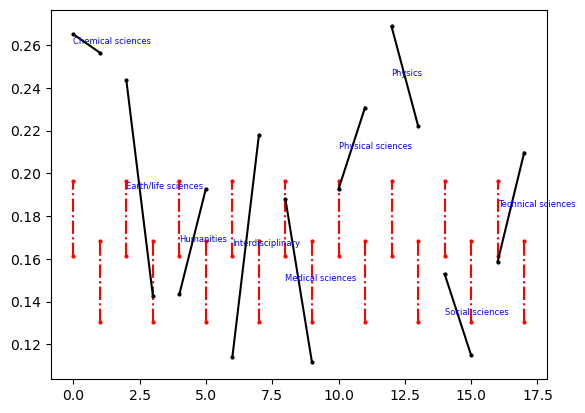

In [108]:
ys = az.hdi(m_11h4_trace)['p'].T.values
nwo_data['awards_pct'] = nwo_data['awards'] / nwo_data['applications']

for i in range(ys.shape[1]):
    plt.plot([i,i] ,[ys[0][i], ys[1][i]],'ro-.', ms=2)
    

for num,dcat in enumerate(dis_cat.categories):
    plot_data = nwo_data[nwo_data['discipline'] == dcat].sort_values('gender', ascending=False)
    plt.plot([num*2,num*2+1],[plot_data['awards_pct'].values[0],plot_data['awards_pct'].values[1]],'ko-', ms=2)
    plt.text(num*2, (plot_data['awards_pct'].values[0]+plot_data['awards_pct'].values[1])/2, dcat, c='b', fontsize=6)

Looking at the posterior plots and the expected percentages, it's not really clear that this model is great given the intervals.  However, it does seem to show that men aren't doing better across all disciplines, but it tends to even out since the model with and without the discipline as a variable presents a similar (but small) benefit for men.  If we look at the original data, it might be the case what women submit more applications in certain fields (e.g. Physics) compared to men, so one might recommend applying more to those fields

# 11H5 Question
Suppose that the NWO Grants sample has an unobserved confound that influences both
choice of discipline and the probability of an award. One example of such a confound could be the
career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the
grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences
discipline as well as the probability of being awarded a grant. Add these influences to your DAG from
the previous problem. What happens now when you condition on discipline? Does it provide an
un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your
answer with the backdoor criterion. If you have trouble thinking this though, try simulating fake
data, assuming your DAG is true. Then analyze it using the model from the previous problem. What
do you conclude? Is it possible for gender to have a real direct causal influence but for a regression
conditioning on both gender and discipline to suggest zero influence?

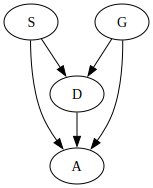

In [114]:
#(D)iscipline,(S)tage,(A)ward,(G)ender
q11h5_graph = CausalGraphicalModel(
    nodes = ['D','G','A','S'],
    edges =[
        ('G','D'),
        ('G','A'),
        ('D','A'),
        ('S','D'),
        ('S','A'),
    ])
    
q11h5_graph.draw()

S is a unobserved variable.  Including Discipline basically opens up a path between Stage and Award.  So it's basically impossible in this situation to fully isolate the influence of Gender on Award.

In [113]:
q11h5_graph.get_all_backdoor_adjustment_sets("G", "A")

frozenset({frozenset(), frozenset({'S'})})

We have to include stage to get the influence of Gender on Award.  But since stage is unobserved, we basically cannot isolate this effect

# 11H6 Question
The data in data(Primates301) are 301 primate species and associated measures. In this
problem, you will consider how brain size is associated with social learning. There are three parts.
(a) Model the number of observations of social_learning for each species as a function of the
log brain size. Use a Poisson distribution for the social_learning outcome variable. Interpret the
resulting posterior. (b) Some species are studied much more than others. So the number of reported
instances of social_learning could be a product of research effort. Use the research_effort
variable, specifically its logarithm, as an additional predictor variable. Interpret the coefficient for log
research_effort. How does this model differ from the previous one? (c) Draw a DAG to represent
how you think the variables social_learning, brain, and research_effort interact. Justify the
DAG with the measured associations in the two models above (and any other models you used)

In [116]:
##11H6
p301_data = pd.read_csv('.\data\Primates301.csv', sep=';')
p301_data.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [117]:
p301_data['log_brain'] = normalize(np.log(p301_data['brain']))
p301_data['log_reffort'] = normalize(np.log(p301_data['research_effort']))
p301_data_dropna = p301_data[['social_learning','brain','log_brain','research_effort','log_reffort']].dropna()
p301_data.shape,p301_data_dropna.shape

((301, 18), (150, 5))

In [119]:
with pm.Model() as m_11h6:
    a = pm.Normal('a',0,0.5)
    b = pm.Normal('b',0,2) 
    p = pm.Deterministic("p", pm.math.exp(a + b*p301_data_dropna['log_brain']))
    social = pm.Poisson('social',mu=p,observed=p301_data_dropna['social_learning'].astype(int))
    m_11h6_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [120]:
az.summary(m_11h6_trace, var_names=['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.287,0.117,-1.517,-1.082,0.003,0.002,1156.0,1171.0,1.0
b,2.858,0.075,2.724,3.000,0.002,0.002,1131.0,1164.0,1.0


We can see that brain size has a strong realtionship with social

In [121]:
with m_11h6:
    ppc = pm.sample_posterior_predictive(
        m_11h6_trace, var_names=["social", "p"]
    )
    pp_p = ppc["posterior_predictive"]["p"]
    pp_social = ppc["posterior_predictive"]["social"]
social_hdi_values = az.hdi(pp_social)['social'].T.values

Sampling: [social]


Text(0.5, 0, 'Social Learning')

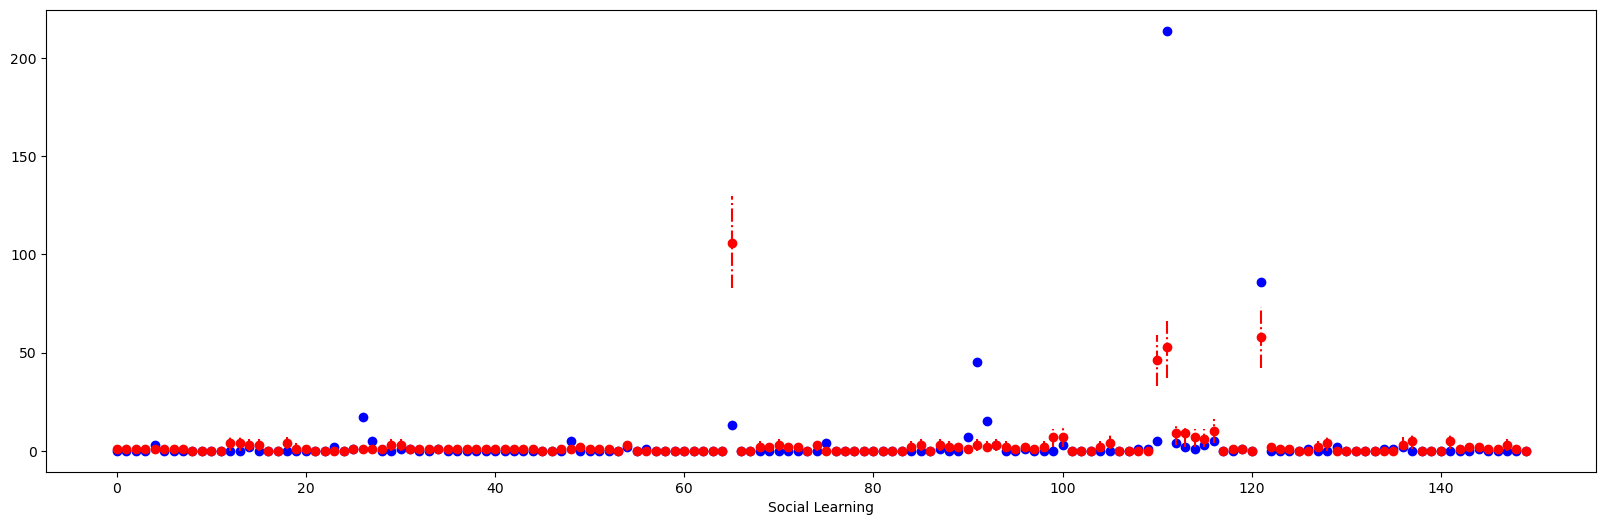

In [122]:
plt.figure(figsize=(20,6))
plt.scatter(range(0,150),p301_data_dropna['social_learning'],c='b')
plt.scatter(range(0,150),np.round(pp_social.mean(['chain','draw']),0).values,c='r')
for i in range(social_hdi_values.shape[1]):
    plt.plot([i,i] ,[social_hdi_values[0][i], social_hdi_values[1][i]],'r-.', ms=1)
plt.xlabel('Row')
plt.xlabel('Social Learning')

The model looks okay, but here are a lot of zeros in the original Social Learning variable, so it's hard to know how great this model is when it clearly misses by quite a lot for values that are more than a few points higher than zero.

In [123]:
with pm.Model() as m_11h6_b:
    a = pm.Normal('a',0,0.5)
    b = pm.Normal('b',0,1)
    re = pm.Normal('re',0,1)
    p = pm.Deterministic("p", pm.math.exp(a + b*p301_data_dropna['log_brain'] + re*p301_data_dropna['log_reffort']))
    social = pm.Poisson('social',mu=p,observed=p301_data_dropna['social_learning'].astype(int))
    m_11h6_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, re]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [124]:
az.summary(m_11h6_b_trace, var_names=['a','b','re'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.880,0.154,-2.159,-1.598,0.004,0.003,1461.0,1587.0,1.0
b,0.408,0.083,0.256,0.564,0.002,0.001,1545.0,1891.0,1.0
re,2.099,0.090,1.929,2.264,0.002,0.002,1303.0,1632.0,1.0


Including research effort weakens the relationship between brain size and social learning by a lot.

In [125]:
with m_11h6_b:
    ppc_with_reffort = pm.sample_posterior_predictive(
        m_11h6_b_trace, var_names=["social", "p"]
    )
    pp_p_with_reffort = ppc_with_reffort["posterior_predictive"]["p"]
    pp_social_with_reffort = ppc_with_reffort["posterior_predictive"]["social"]

Sampling: [social]


Text(0.5, 0, 'Social Learning')

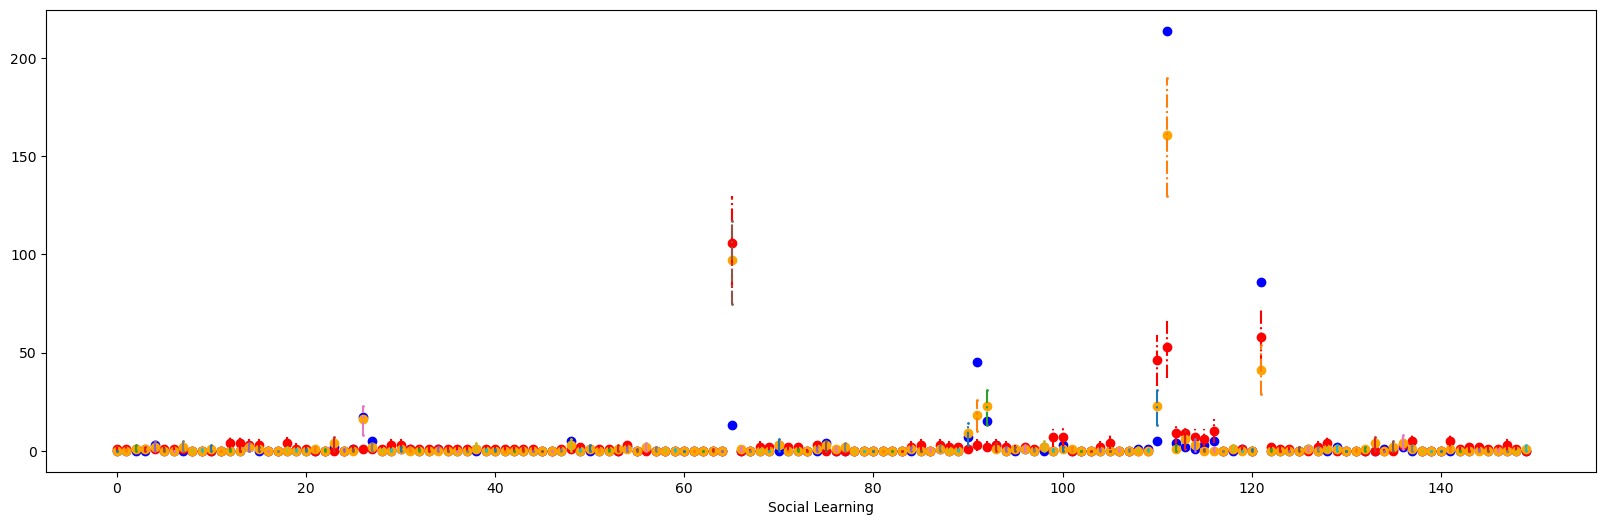

In [128]:
social_hdi_values_with_reffort = az.hdi(pp_social_with_reffort)['social'].T.values
plt.figure(figsize=(20,6))
plt.scatter(range(0,150),p301_data_dropna['social_learning'],c='b')
plt.scatter(range(0,150),np.round(pp_social.mean(['chain','draw']),0).values,c='r')
plt.scatter(range(0,150),np.round(pp_social_with_reffort.mean(['chain','draw']),0).values,c='orange')
for i in range(social_hdi_values.shape[1]):
    plt.plot([i,i] ,[social_hdi_values[0][i], social_hdi_values[1][i]],'r-.', ms=1)
for i in range(social_hdi_values_with_reffort.shape[1]):
    plt.plot([i,i] ,[social_hdi_values_with_reffort[0][i], social_hdi_values_with_reffort[1][i]],'o-.', ms=1)
plt.xlabel('Row')
plt.xlabel('Social Learning')

In [129]:
compare_m11h6 = {
    "Brain Size": m_11h6_trace, 
    "With Research EFfort": m_11h6_b_trace,}
az.compare(compare_m11h6, ic='loo',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: S

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
With Research EFfort,0,552.509045,48.145207,0.000000,0.888912,164.005026,0.000000,True,deviance
Brain Size,1,1339.700670,94.220111,787.191625,0.111088,412.576825,330.140361,True,deviance


We can see that adding research effort improves the model by quite a lot.  If we look at the plot, the predictions seem better as well, but there quite a few of the predcitions are bad.  Given how many zeros are in the data, it's hard to judge the quality of the models

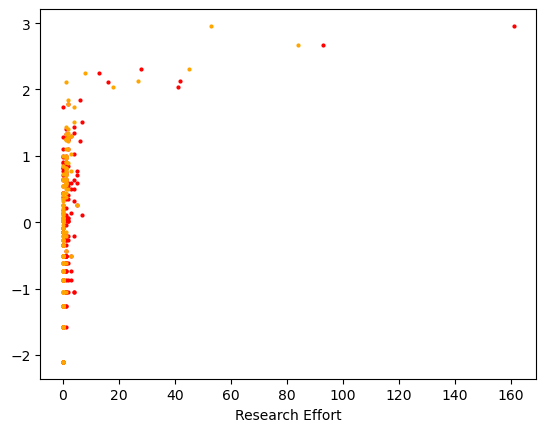

In [130]:
errors = np.abs(p301_data_dropna['social_learning'] - np.round(pp_social.mean(['chain','draw']),0))
errors_with_reffort = np.abs(p301_data_dropna['social_learning'] - np.round(pp_social_with_reffort.mean(['chain','draw']),0))
plt.scatter(errors,p301_data_dropna['log_reffort'],c='r',s=4)
plt.scatter(errors_with_reffort,p301_data_dropna['log_reffort'],c='orange',s=4)
plt.xlabel('Error From Acutal')
plt.xlabel('Research Effort')
plt.show()

It looks like the second model does better in general, but the errors are smaller with the second model (compared to the first) where the research effort is higher.  This leads to an interesting question.  Let's look at a plot

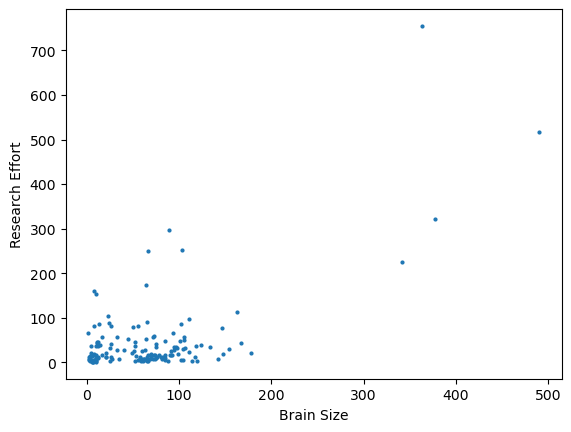

In [131]:
plt.scatter(p301_data_dropna['brain'],p301_data_dropna['research_effort'],s=4)
plt.xlabel('Brain Size')
plt.ylabel('Research Effort')
plt.show()

It looks like more research effort is put into primates with bigger brain sizes, which may mean that the lower the brain size, the less reliable the actual brain size measurement might be.  That might provide some insight into all the zeros in the social interaction since maybe some of those are not accurate.

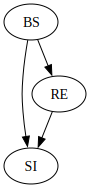

In [132]:
q11h6_graph = CausalGraphicalModel(
    nodes = ['SI','BS','RE'],
    edges =[
        ('BS','RE'),
        ('BS','SI'),
        ('RE','SI'),
    ])
    
q11h6_graph.draw()

Basically, brain size has a direct path to social interaction, but it is also influences research effort.  So research effort becomes a pipe for social interaction since less research effort influences the act of measuring and documenting the values in the social interaction variable.